# Risk-Averse RL in the Guarded Maze

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import gym
import GuardedMaze
import GuardedMazeLab as GML
import Agents
import utils

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)
torch.set_printoptions(linewidth=150)

In [2]:
# Whether to load existing results or train new agents
LOAD_ONLY = True

## The Guarded Maze benchmark

* **Goal**: get to the green target, whose location is constant. The agent starts at a random point in the lower left quarter of the maze. The red zone may be guarded, such that crossing it would cost the agent. The agent knows the red zone but does not know whether it is occupied and how high the cost is in the current episode.
* **Observation**: the agent location `x,y` (see `get_obs()` in `GuardedMaze.py`). In practice, this is preprocessed into a soft (continuous) one-hot representation before feeding as an input for the policy (see `get_agent_input()` in `GuardedMazeLab.py`).
* **Actions**: left/right/up/down. Each action is accomanied by an additive multivariate noise whose scale is 20% of the step unit.
* **Rewards**: `-1` for every step until reaching the target or up to 32 steps. `+16` for reaching the goal. A random negative reward with a certain probability when crossing the red zone (up to one time per episode).
* **What does the simulation control?** the probability that the red zone is guarded, and the expected cost of being spotted by a guard.

A sample episode of a random agent:

Return: -32


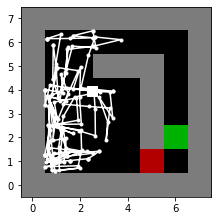

In [3]:
# Make sure the environment is registered
if 'GuardedMazeEnv-v0' in gym.envs.registry.env_specs:
    del gym.envs.registry.env_specs['GuardedMazeEnv-v0']
gym.envs.registration.register(id='GuardedMazeEnv-v0', entry_point='GuardedMaze:GuardedMaze')

# Load env
env = gym.make('GuardedMazeEnv-v0')
env.reset(init_state=(1,1))

# Run episode (with random actions)
done = False
while not done:
    obs, r, done, info = env.step(env.action_space.sample())

# Summarize episode
print('Return:', info['r'])
env._show_state()
env.close()

## CE for risk-averse RL on the Guarded Maze

Bernoulli-distributed guard-presence in the guarded zone ($\phi_1=20\%$); exponentially-distributed guard-cost (with average $\phi_2=$ twice the goal reward); 
CVaR optimization in this case is with respect to the Bernoulli and Exponential distributions parameterized by $\phi$.

In [4]:
%%time

experiment_args = dict(guard_prob=0.2, guard_cost=2, rand_cost=True, title='GuardedMaze')

# Define agents (note that the training hyperparams are also defined here through the dict train_hparams)
agents = dict(
    PG = (Agents.FC, dict()),
    GCVaR = (Agents.FC, dict(train_hparams=dict(cvar=0.05))),
    CeR = (Agents.FC, dict(train_hparams=dict(cvar=0.05, ce_update_freq=1))),  # CE
    SoR = (Agents.FC, dict(train_hparams=dict(cvar=0.05, soft_cvar=0.8))),  # Soft
    CeSoR = (Agents.FC, dict(train_hparams=dict(cvar=0.05, ce_update_freq=1, soft_cvar=0.8))),  # + CE + Soft
);

# Run experiment
E = GML.Experiment(agents, train_episodes=100000, **experiment_args)
if LOAD_ONLY:
    E.load_results(agents=True, optimizers=True, CEs=True)
else:
    E.train()
    E.test()
    E.save_results()

E.dd

Wall time: 52.3 s


,agent,group,episode,ag_updates,ag_hash,ag_temperature,guard_prob,guard_cost,s0_x,s0_y,path,log_prob,ret_loss,score,opt_selected,ce_selected,weight
0,PG,train,0,0,-0x55715a8e91db2c93,1,0.0,0.343643,2.263931,2.349212,-1.0,-19.129902,25.083248,3.000000,1.0,NaN,NaN
1,PG,train,1,0,-0x55715a8e91db2c93,1,1.0,0.182322,3.123762,2.764829,-1.0,-222.731247,-48.653355,-34.917153,1.0,NaN,NaN
2,PG,train,2,0,-0x55715a8e91db2c93,1,0.0,1.361527,0.684101,2.089320,-1.0,-221.831146,-44.334873,-32.000000,1.0,NaN,NaN
3,PG,train,3,0,-0x55715a8e91db2c93,1,0.0,1.132638,3.380636,1.491171,-1.0,-95.365875,-0.961153,-16.000000,1.0,NaN,NaN
4,PG,train,4,0,-0x55715a8e91db2c93,1,0.0,2.351921,2.600820,3.023830,-1.0,-83.239159,0.360707,-16.000000,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505295,CeSoR,test,1055,250,0x2e096f5d72572126,0,0.0,5.471613,2.510324,3.471415,1.0,-1.216277,9.035548,4.000000,NaN,NaN,NaN
505296,CeSoR,test,1056,250,0x2e096f5d72572126,0,1.0,1.659938,2.656521,2.744929,1.0,-0.952476,9.267968,7.000000,NaN,NaN,NaN
505297,CeSoR,test,1057,250,0x2e096f5d72572126,0,0.0,0.810381,3.246584,0.995117,1.0,-2.121327,10.492018,-2.000000,NaN,NaN,NaN
505298,CeSoR,test,1058,250,0x2e096f5d72572126,0,0.0,1.264910,2.375994,1.485853,1.0,-1.224455,0.625663,2.000000,NaN,NaN,NaN


### Experiment analysis

PG (250/250):	mean=4.2	CVaR10=-40.3	CVaR05=-63.3
GCVaR (250/250):	mean=-32.0	CVaR10=-32.0	CVaR05=-32.0
CeR (250/250):	mean=-32.0	CVaR10=-32.0	CVaR05=-32.0
SoR (0/250):	mean=-32.2	CVaR10=-34.6	CVaR05=-37.2
CeSoR (220/250):	mean=2.0	CVaR10=-4.6	CVaR05=-6.7
Wall time: 2min 54s


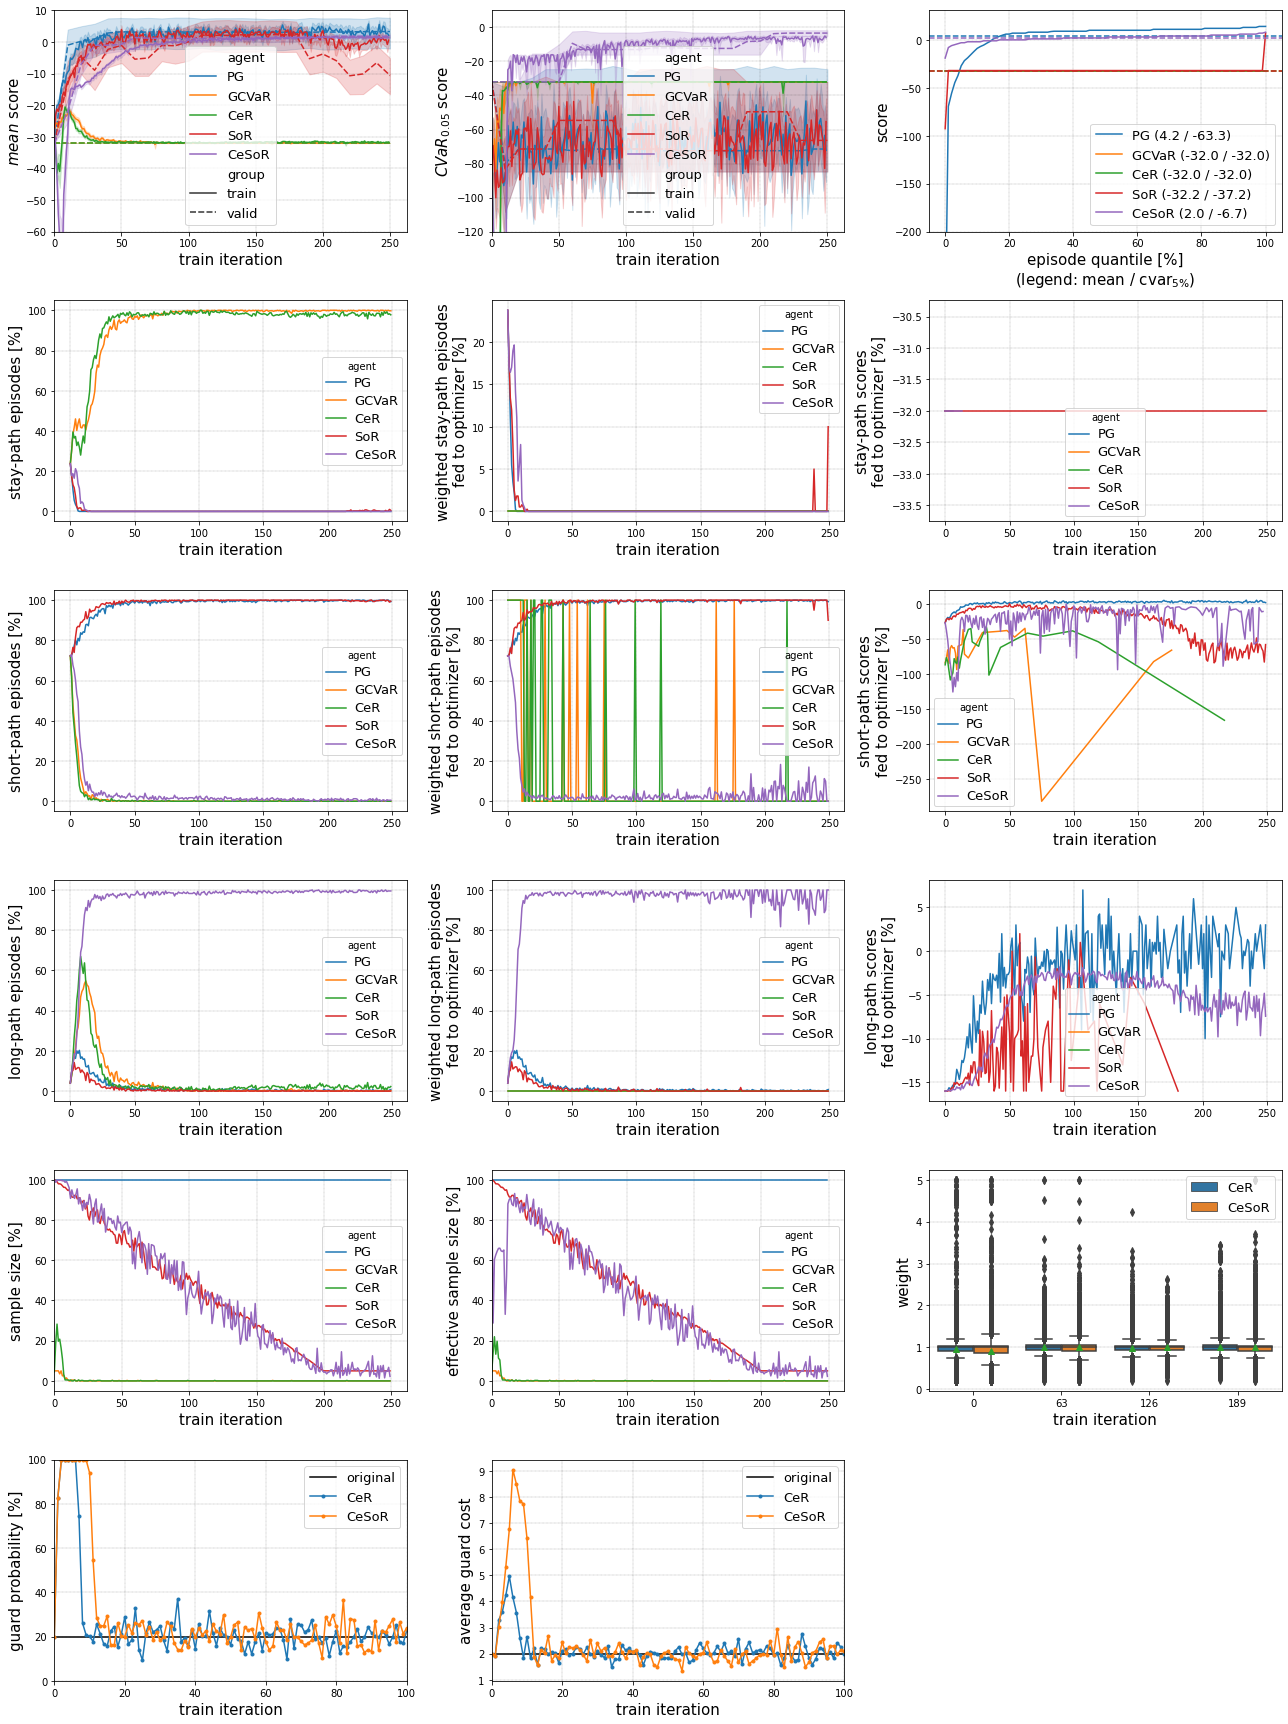

In [5]:
%%time

axs = E.analyze()

axs[0].set_ylim((max(axs[0].get_ylim()[0],-60),10))
axs[1].set_ylim((max(axs[1].get_ylim()[0],-120),10))
axs[2].set_ylim((max(axs[2].get_ylim()[0],-200),None))
axs[2].legend(fontsize=13, loc='lower right')
axs[0].legend(fontsize=13, loc='lower center')
axs[1].legend(fontsize=13, loc='lower center')
axs[2].legend(fontsize=13, loc='lower right')
axs[15].set_xlim((0,100))
axs[16].set_xlim((0,100))
plt.savefig(f'outputs/{experiment_args["title"]}_summary.png', bbox_inches='tight');

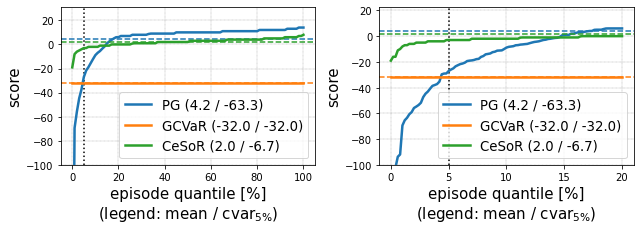

In [6]:
test_df = E.dd[E.dd.group=='test']
axs = utils.Axes(2, 2, (4.5,3.3), fontsize=15)
a = 0

n_iters = E.n_train // E.optim_freq
cvar = lambda x, alpha: np.mean(np.sort(x)[:int(np.ceil(alpha*len(x)))])
for q in (100, 20):
    axs[a].axvline(5, color='k', linestyle=':')
    for agent in ('PG', 'GCVaR', 'CeSoR'):
        scores = test_df.score[test_df.agent==agent].values
        utils.plot_quantiles(
            scores, q=np.linspace(0,q,101)/100, ax=axs[a], linewidth=2.5, showmeans=True,
            label=f'{agent} ({np.mean(scores):.1f} / {cvar(scores,0.05):.1f})')
    axs[a].set_ylim((-100,None))
    axs.labs(a, 'episode quantile [%]\n(legend: mean / cvar$_{5\%}$)', 'score')
    axs[a].legend(fontsize=13.3)
    a += 1
plt.tight_layout()
plt.savefig(f'outputs/{experiment_args["title"]}_test.png', bbox_inches='tight');

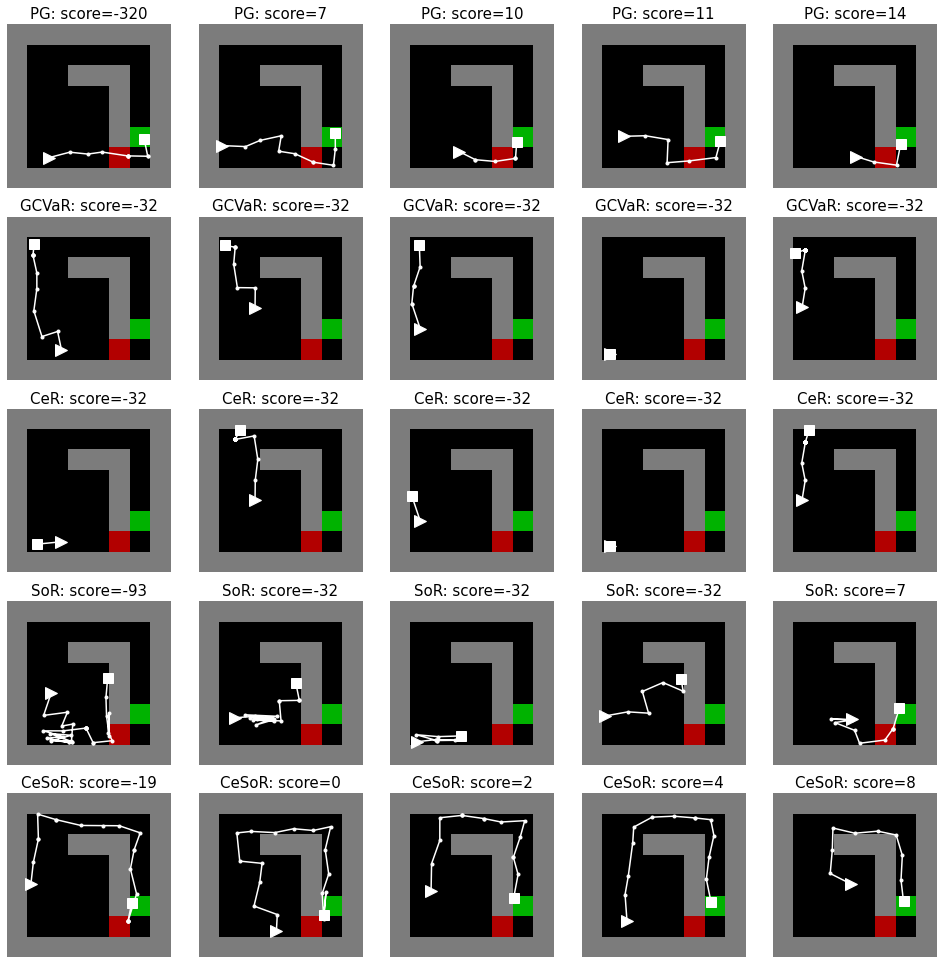

In [7]:
E.show_tests()
plt.savefig(f'outputs/{experiment_args["title"]}_examples.png', bbox_inches='tight');

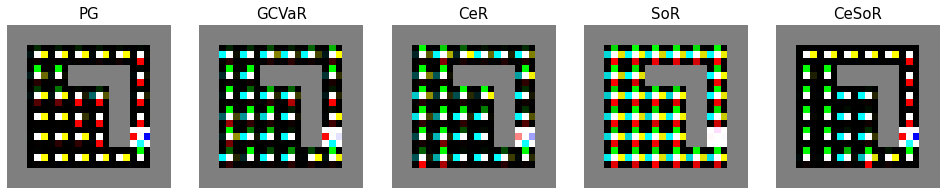

In [8]:
E.visualize_policies()
plt.savefig(f'outputs/{experiment_args["title"]}_policies.png', bbox_inches='tight');

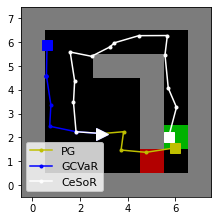

In [53]:
episode = 901
env = E.env
colors = ['y', 'b', 'w']
ax = utils.Axes(1, 1, grid=False)[0]
for i, agent in enumerate(('PG', 'GCVaR', 'CeSoR')):
    E.run_episode((agent, 'test', episode), E.agents[agent], ax=None, verbose=0)
    if i == 0:
        env._show_state(ax, show_traj=False)
    track = np.concatenate(env.state_traj)
    ax.plot(track[:, 0], track[:, 1], f'{colors[i]}.-', label=agent)
    ax.plot(track[:1, 0], track[:1, 1], f'{colors[i]}>', markersize=12)
    ax.plot(track[-1:, 0], track[-1:, 1], f'{colors[i]}s', markersize=10)
ax.legend(fontsize=11, loc='lower left')
plt.savefig(f'outputs/{experiment_args["title"]}_ep{episode}.png', bbox_inches='tight');

### Optimizer analysis

Long-path episodes per batch (a) in total; (b) among the episodes fed to the optimizer, with weights taken into account.
Only first 100 iterations are shown for clarity.
For GCVaR and CeR, the long-path episodes never make it into the bottom 5% of the batch, hence are not fed to the optimizer and cannot be learned. Their percent increases in the beginning as a side-effect of the short-path avoidance, but they are never explicitly encouraged and thus decay over time in favour of the stay-path.
For SoR, the long-path episodes are fed to the optimizer but are considered worse than the short-path, thus learned to be entirely avoided by the time the soft-$\alpha$ reaches its low target level.
Only for CeSoR, the long-path episodes are both visible and considered a positive example to be learned.

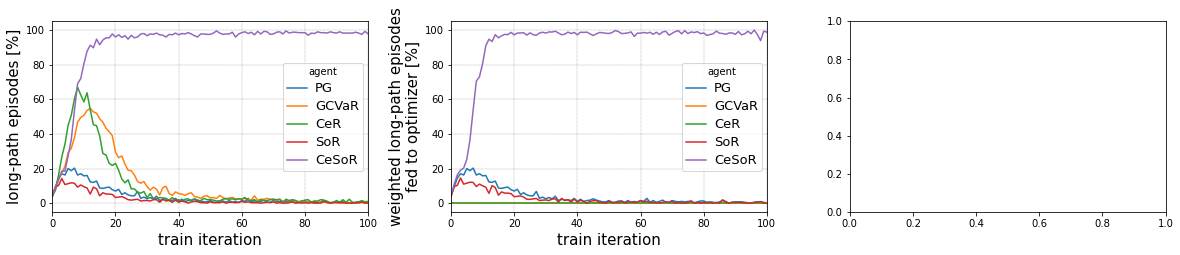

In [13]:
o = pd.concat([E.optimizers[ag].get_data()[1] for ag in E.agents_names])
o['agent'] = o.title
o.reset_index(drop=True, inplace=True)
axs = E.analyze_exposure(o, E.agents_names, track='long')
for a in range(3):
    axs[a].set_xlim((0,100))
axs[2].clear()
plt.tight_layout()
plt.savefig(f'outputs/{experiment_args["title"]}_longs.png', bbox_inches='tight');

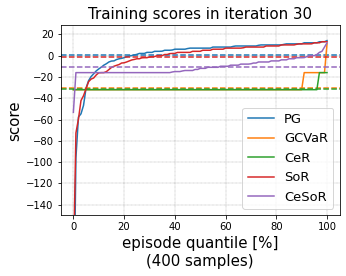

In [11]:
it = 30
ax = utils.qplot(E.dd[E.dd.ag_updates==it], 'score', 'episode', 'agent');
ax.set_title(f'Training scores in iteration {it}', fontsize=15);
ax.set_ylim((-150,None));
plt.savefig(f'outputs/{experiment_args["title"]}_train_scores.png', bbox_inches='tight');

### CE distribution analysis

The average and CVaR returns of the CeSoR agent during the training, over episodes whose configurations were drawn from (1) the original distribution, and (2) the CE sample distribution.
Only first 60 iterations are shown for clarity.
In the beginning, the CE sample distribution learns the difficult conditions, such that its mean quickly follows the original distribution's CVaR.
Later, as the agent learns to perform robustly and independently of the conditions (by taking the long path), the sample distribution aligns with the original distribution (in both mean and CVaR).

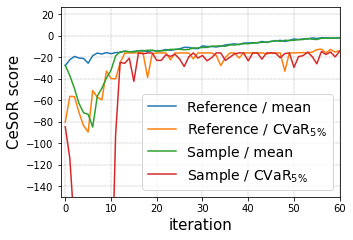

In [12]:
ax = utils.Axes(1,1)[0]
agent_name = 'CeSoR'
E.CEs[agent_name].show_sampled_scores(ax, f'{agent_name} score')
ax.set_xlim((-1,60))
ax.set_ylim((-150, None))
plt.savefig(f'outputs/{experiment_args["title"]}_CE.png', bbox_inches='tight');